In [1]:
from csv import reader
import pandas as pd
import numpy as np
import os, glob, cv2, Classify, Hog

def extract_info_from_name(hog_set):
    s = hog_set.split('/')[-1]
    s = s.split('-')
    base_size = int(s[0])
    pixels_per_cell = eval(s[1])
    cells_per_block = eval(s[2])
    method = getattr(Hog,s[3])
    return method, base_size, pixels_per_cell, cells_per_block

def fetch_paths(folder_to_test, hog_set):
    folder_pwd = os.getcwd()
    os.chdir('..')
    os.chdir('../resources/Data - BabyWatcher/Test')
    csv_path = os.getcwd()

    os.chdir(folder_to_test)
    img_path = os.getcwd()

    os.chdir('../../'+hog_set)
    svm_path = os.getcwd()
    os.chdir('..')
    save_path = os.getcwd()

    os.chdir(folder_pwd)
    return csv_path, img_path, save_path, svm_path

def analyse(image_path, image_name):
    if isinstance(image_name, list):
        a = []
        a_n = []
        p = []
        p_a = []
        for i in range(len(image_name)):
            print('{}/{}'.format(i+1,len(image_name)), end=' ')
            a1, p1, p_a1 = analyse(image_path, image_name[i])
            a.append(a1)
            a_n.append(image_name[i])
            p.append(p1)
            p_a.append(p_a1)
        return dict(zip(a_n, a)), pd.concat(p), pd.concat(p_a)

    img = cv2.imread(image_path+'/'+image_name, 0)
    
    analysed_image, pred, all_pred = Classify.analyse_image(img, classifiers, crop_thresh=0.2, blur_size=10, bright_strength=1, sharp_strength=1,
                  square_step=True, hog_func=method, base_size=base_size, step=16, sizes=[64, 96, 128, 160,192, 224],
                  orientations=9,
                  pixels_per_cell=pixels_per_cell,
                  cells_per_block=cells_per_block, pred_threshold=0.90)

    pred['img'] = image_name
    all_pred['img'] = image_name
    return analysed_image, pred, all_pred


def analyse_timed(image_path, image_name, save_path=None):
    from timeit import default_timer as timer
        
    if isinstance(image_name, list):
        from pathlib import Path
        
        a = dict()
        p = []
        p_a = []
        for i in range(len(image_name)):
            print('{}/{}'.format(i+1,len(image_name)), end=' ')
            a1, p1, p_a1 = analyse_timed(image_path, image_name[i], save_path=save_path)
        if save_path is not None:
            for f in os.listdir(save_path+'/temp/all_prediction'):
                p_a.append(pd.read_csv(save_path+'/temp/all_prediction/'+f))

            for f in os.listdir(save_path+'/temp/prediction'):
                p.append(pd.read_csv(save_path+'/temp/prediction/'+f))

            for f in os.listdir(save_path+'/temp/anot'):
                a[f] = cv2.imread(save_path+'/temp/anot/'+f)
    
        return a, pd.concat(p), pd.concat(p_a)

    img = cv2.imread(image_path+'/'+image_name, 0)
    
    
    start = timer()
    
    analysed_image, pred, all_pred = Classify.analyse_image(img, classifiers, crop_thresh=0.2, blur_size=10, bright_strength=1, sharp_strength=1,
                  square_step=True, hog_func=method, base_size=base_size, step=32, sizes=[64, 96, 128, 160,192, 224],
                  orientations=9,
                  pixels_per_cell=pixels_per_cell,
                  cells_per_block=cells_per_block, pred_threshold=0.90)

    end = timer()
    
    pred['time'] = end-start
    all_pred['time'] = end-start

    pred['img'] = image_name
    all_pred['img'] = image_name
    
    if save_path is not None:
        from pathlib import Path
        def save_anot(anotated_img, img_name):
            p = save_path+'/temp/anot'
            Path(p).mkdir(parents=True, exist_ok=True)
            cv2.imwrite(p+'/'+img_name, anotated_img)

        def save_pred(prediction, img_name):
            p = save_path+'/temp/prediction'
            Path(p).mkdir(parents=True, exist_ok=True)
            prediction.to_csv(p+'/'+img_name[:-4]+'.csv', index=False)

        def save_all_pred(all_prediction, img_name):
            p = save_path+'/temp/all_prediction'
            Path(p).mkdir(parents=True, exist_ok=True)
            all_prediction.to_csv(p+'/'+img_name[:-4]+'.csv', index=False)
        
        save_anot(analysed_image, image_name)
        save_pred(pred.drop(columns=['window_size','window']), image_name)
        save_all_pred(all_pred.drop(columns=['window_size','window']), image_name)
        
    return analysed_image, pred, all_pred

In [2]:
folders_to_test = ['Images']# ,'Gaussian Noise', 'Test x2 contrast', 'Test x5 contrast', 'Test x10 contrast']
svms_to_test = ['Zain/SVM/128-(16, 16)-(4, 4)-compute_hog1']
               #,'All/SVM/128-(16, 16)-(4, 4)-compute_hog1']
               #'Zain/SVM/128-(16, 16)-(2, 2)-compute_hog1'
               #,'Zain/SVM/128-(16, 16)-(2, 2)-compute_hog'
               #,'Zain/SVM/128-(8, 8)-(2, 2)-compute_hog1'
               #,'Zain/SVM/128-(8, 8)-(2, 2)-compute_hog' 
               #,'Zain/SVM/96-(16, 16)-(2, 2)-compute_hog1' 
               #,'Zain/SVM/96-(16, 16)-(2, 2)-compute_hog']

In [3]:
for folder_to_test in folders_to_test:
    for svm_to_test in svms_to_test:
        print(folder_to_test, svm_to_test)
        csv_path, img_path, save_path, svm_path = fetch_paths(folder_to_test,svm_to_test)
        print('csv_path: '+csv_path+'\nimg_path: '+img_path+'\nsave_path: '+save_path+'\nsvm_path: '+svm_path)

        # Load CSV
        test_set = pd.read_csv(csv_path+'\pre-processed.csv')
        print(test_set.columns.tolist())

        # Load Classifiers
        classifiers = Classify.load_svm(svm_path+'-feedback')

        # Extract HOG settings from name
        method, base_size, pixels_per_cell, cells_per_block = extract_info_from_name(svm_to_test)

        import shutil
        dirpath = save_path+'/temp'
        shutil.rmtree(dirpath, ignore_errors=True)

        anot_img, preds, all_preds = analyse_timed(img_path, test_set['img'].unique().tolist(), save_path=save_path)

        save_df = preds#[['x', 'y', 'real_size', 'feature', 'prediction_val', 'verification', 'img', 'time']]
        save_df.to_csv(save_path+'/'+folder_to_test+'-'+svm_to_test.split('/')[-1]+'-feedback.csv', index=False)

Images Zain/SVM/128-(16, 16)-(4, 4)-compute_hog1
csv_path: C:\Users\emery\IdeaProjects\Project3-1\resources\Data - BabyWatcher\Test
img_path: C:\Users\emery\IdeaProjects\Project3-1\resources\Data - BabyWatcher\Test\Images
save_path: C:\Users\emery\IdeaProjects\Project3-1\resources\Data - BabyWatcher\Zain\SVM
svm_path: C:\Users\emery\IdeaProjects\Project3-1\resources\Data - BabyWatcher\Zain\SVM\128-(16, 16)-(4, 4)-compute_hog1
['type', 'x', 'y', 'img', 'from_file', 'size']
1/370 2/370 3/370 4/370 5/370 6/370 7/370 8/370 9/370 10/370 11/370 12/370 13/370 14/370 15/370 16/370 17/370 18/370 19/370 20/370 21/370 22/370 23/370 24/370 25/370 26/370 27/370 28/370 29/370 30/370 31/370 32/370 33/370 34/370 35/370 36/370 37/370 38/370 39/370 40/370 41/370 42/370 43/370 44/370 45/370 46/370 47/370 48/370 49/370 50/370 51/370 52/370 53/370 54/370 55/370 56/370 57/370 58/370 59/370 60/370 61/370 62/370 63/370 64/370 65/370 66/370 67/370 68/370 69/370 70/370 71/370 72/370 73/370 74/370 75/370 76/370 

df = all_preds[(all_preds['prediction_val']>0) & (all_preds['feature']!='none')]
def iou(row):
    if row[['found_x', 'x']].isna().any():
        row['iou'] = 0
        return row
    boxA = [row['found_x'], row['found_y'], row['found_x']+row['real_size'], row['found_y']+row['real_size']]
    boxB = [row['x'], row['y'], row['x']+row['size'], row['y']+row['size']]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / min(boxAArea, boxBArea)
    row['iou'] = iou
    return row

l = []
t = test_set.copy().rename(columns={'x':'y', 'y':'x'})
t = t[t['type']!='none']
df = df.rename(columns={'feature':'type', 'x':'found_x', 'y':'found_y'})
joined = df.merge(t[t['img'].isin(df['img'].unique())], on=['img'], how='outer')
joined = joined.apply(iou, axis=1)
joined['result'] = ''
joined.loc[joined['iou']<0.5, 'result'] = 0
joined.loc[joined['found_x'].isna(),'result'] = 2
joined.loc[joined['x'].isna(),'result'] = 0
joined.loc[joined['iou']>=0.5, 'result'] = 1
l.append(joined)

analysed = pd.concat(l).reset_index(drop=True)

analysed = analysed[analysed['result']!=2]
s = pd.DataFrame(analysed.groupby(['found_x', 'found_y', 'real_size', 'img'])['result'].max())
s = s[s['result']==0]
l = []
def fetch(row):
    l.append(analysed[(analysed['found_x']==row['found_x']) & (analysed['found_y']==row['found_y']) & (analysed['real_size']==row['real_size']) & (analysed['img']==row['img'])])
s.reset_index().apply(fetch, axis=1)
none = pd.concat(l)

df = pd.DataFrame()
df['type'] = 'none'
df['x'] = none['found_y']
df['y'] = none['found_x']
df['width'] = none['real_size']
df['height'] = none['real_size']
df['img'] = none['img']
df['full_width'] = 800
df['full_height'] = 480
df[['x', 'y', 'width', 'height']] = df[['x', 'y', 'width', 'height']].astype(int)
df['type'] = 'none'
df.reset_index(drop=True).to_csv('C:/Users/emery/IdeaProjects/Project3-1/resources/Data - BabyWatcher/Zain/miss_classified.csv', index=False, header=False)

def extract_sub(row):
    img = cv2.imread(img_path+'/'+row['img'])
    def add_rect(start, end,img_c, color=(255, 0, 0)):
        img_c = cv2.rectangle(img_c, start, end, color, 2)
        img_c = cv2.putText(img_c, row['type_x'], (start[0], start[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    if row['found_x'] == row['found_x']:
        add_rect((int(row['found_y']), int(row['found_x'])), (int(row['found_y']+row['real_size']), int(row['real_size']+row['found_x'])),img_c= img)
    if row['x'] == row['x']:
        add_rect((int(row['y']), int(row['x'])), (int(row['y']+row['size']), int(row['size']+row['x'])), color=(0,0,255), img_c=img)
    return img

df = none.reset_index(drop=True)
#df['sub'] = df.apply(extract_sub, axis=1)
#slideshow(df['sub'].tolist(),df[[ 'type_y', 'prediction_val', 'result']].astype(str).agg(' - '.join, axis=1).tolist())
df

# Manual checking

In [11]:
check_imgs = dict()
def draw(img_n, img, test_set):
    img_c = img.copy()
    t = test_set[test_set['img']==img_n]
    
    def add_rect(row, img_c):
        start = (int(row['x']), int(row['y']))
        end = (int(row['x']+row['size']), int(row['y']+row['size']))
        color = (0, 0, 255)
        img_c = cv2.rectangle(img_c, start, end, color, 2)
        img_c = cv2.putText(img_c, row['type'], (int(row['x']), int(row['y']) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    t.apply(add_rect, img_c=img_c,axis=1)
    return img_c

for it in anot_img.items():
    check_imgs[it[0]] = draw(it[0], it[1], test_set)

<IPython.core.display.Javascript object>


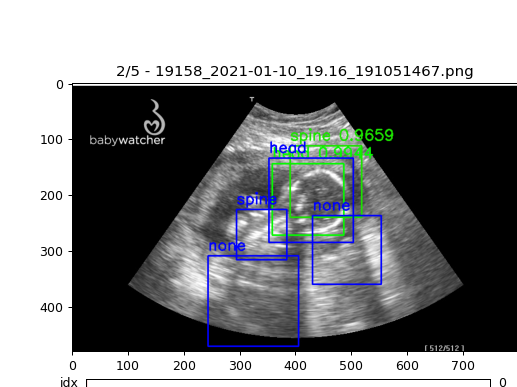

In [12]:
def slideshow(img_list, title_list=[]):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.widgets import Slider, Button, RadioButtons
    %matplotlib notebook
    fig = plt.figure()
    viewer = fig.add_subplot(111)

    fig.show()
    axcolor = 'lightgoldenrodyellow'
    axmax  = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    smax = Slider(axmax, 'idx', 0, len(img_list)-1,valinit=0, valstep=1)

    def arrow_key_image_control(event):
        if event.key=='a':
            update((smax.val-1)%len(img_list))
        if event.key=='d':
            update((smax.val+1)%len(img_list))

    def update(val):
        smax.val = val
        viewer.clear() # Clears the previous image
        viewer.imshow(img_list[int(smax.val)], cmap='gray') # Loads the new image
        s = str(smax.val+1)+'/'+str(len(img_list))
        if len(title_list) > smax.val:
            s+= ' - '+title_list[smax.val]
        viewer.set_title(s)
        plt.pause(0.01) # Delay in seconds
        fig.canvas.draw() # Draws the image tod the screen

    smax.on_changed(update)
    cid = fig.canvas.mpl_connect('key_press_event', arrow_key_image_control)
    viewer.imshow(img_list[0], cmap='gray')

slideshow(list(check_imgs.values()), preds['img'].unique().tolist())

In [15]:
df = all_preds[all_preds['img']==list(check_imgs.keys())[4]]
df = df[df['feature']!='none']

In [16]:
df

,x,y,real_size,arm,foot,hand,head,leg,none,spine,feature,prediction_val,time,img
160,192,512,64,0.9272,0.0,0.0260,0.0000,0.0054,0.8392,0.0061,arm,0.9272,23.815849,19165_2021-08-27_11.43_11432590.png
213,256,672,64,0.0060,0.0,0.0513,0.8548,0.0132,0.8445,0.0077,head,0.8548,23.815849,19165_2021-08-27_11.43_11432590.png
541,256,672,96,0.0048,0.0,0.0143,0.8471,0.0035,0.8410,0.0841,head,0.8471,23.815849,19165_2021-08-27_11.43_11432590.png
782,192,480,128,0.8958,0.0,0.0154,0.0029,0.0000,0.8390,0.0519,arm,0.8958,23.815849,19165_2021-08-27_11.43_11432590.png
849,288,512,128,0.0063,0.0,0.8756,0.1600,0.0000,0.8256,0.0046,hand,0.8756,23.815849,19165_2021-08-27_11.43_11432590.png
995,128,384,160,0.0271,0.0,0.0191,0.9290,0.0118,0.8338,0.0102,head,0.9290,23.815849,19165_2021-08-27_11.43_11432590.png
1066,224,640,160,0.0039,0.0,0.3857,0.8955,0.0057,0.7819,0.0176,head,0.8955,23.815849,19165_2021-08-27_11.43_11432590.png
1242,160,384,192,0.0029,0.0,0.0000,0.0000,0.0000,0.8427,0.9412,spine,0.9412,23.815849,19165_2021-08-27_11.43_11432590.png
1280,224,320,192,0.0081,0.0,0.0122,0.8550,0.0059,0.8525,0.0035,head,0.8550,23.815849,19165_2021-08-27_11.43_11432590.png
1289,224,608,192,0.0026,0.0,0.0486,0.8504,0.0035,0.8447,0.0266,head,0.8504,23.815849,19165_2021-08-27_11.43_11432590.png
